### BBC News: Topic Modelling - LDA

In [2]:
import re
import pandas as pd
import numpy as np

from pymystem3 import Mystem
from nltk.corpus import stopwords
from collections import defaultdict
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib import rcParams

import warnings; warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df = pd.read_csv('data/bbc_news.csv')
df.sample(5)

,news_data,class_label
12595,UK mobile owners continue to break records wit...,tech
2701,The TV couple's interest in the book world coi...,entertainment
8966,Newcastle have joined the race to sign Real Ma...,sport
10983,"""We are, for the first time, able to run this ...",tech
11734,"More than 277 million enquiries were made, ask...",tech


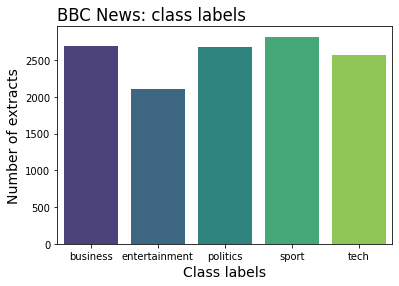

In [4]:
ax = sns.countplot(df.class_label, palette="viridis")
ax.set_title('BBC News: class labels', loc='left', fontsize=16.5)
ax.set_xlabel('Class labels', fontsize=14)
ax.set_ylabel('Number of extracts', fontsize=14)
rcParams['figure.figsize'] = 6.3, 4

In [5]:
# Data preprocessing
regex = re.compile("[A-z]+")
stopwords = stopwords.words('english') + ['mr', 'ms', 'us', 'would', 'bn', 'also',\
                                          'said', 'say', 'could', 'one', 'two',\
                                          'three', 'six', 'told', 'e', 'news', 'year',\
                                          'first', 'second', 'good', 'well', 'use', 'used']
stem = Mystem()


def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


def remove_stopwords(text, stopword_set=stopwords):
    try:
        return " ".join([token for token in text.split() if not token in stopword_set])
    except:
        return ""


def lemmatize(text, stem=stem):
    try:
        return "".join(stem.lemmatize(text)).strip()
    except:
        return " "

In [6]:
# Sample news_data according to its class: business, entertainment,
# politics, sport, tech), and process it
def get_data(dataset, column: str, label_name: str):
    data = dataset.groupby(dataset[column]).get_group(label_name)
    print(f'Dataset size: {len(data)}')
    return data


def process_data(dataset, column: str):
    texts = [dataset[column].iloc[i].split() for i in range(len(dataset))]

    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    # Remove words occurred less than once
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    print(f'Sample from texts: {texts[:2]}')
    return texts


# Create dictionary and corpus
def get_dict_corpus(text):
    dictionary = Dictionary(text)
    corpus = [dictionary.doc2bow(text) for text in text]

    print(f"Dictionary size: {len(dictionary)}")
    print(f"Sample from corpus: {corpus[:2]}")
    return dictionary, corpus

In [7]:
# Word Cloud of top n keywords in each topic
def show_wordcloud(model, stopwords=stopwords, words: int=10,
                   nrows=2, ncols=2, figsize=(6.5, 6.5)):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stopwords,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=words,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize,
                             sharex=True, sharey=True)
    if len(topics) % 2 != 0:
        axes[-1][-1].set_visible(False)

    for i, ax in enumerate(topics):  # axes.flatten()
        ax = plt.subplot(nrows, ncols, i + 1)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()


# Coherence score
def show_coherence_score(model, texts, dict):
    coherence_lda = CoherenceModel(model=model, texts=texts, dictionary=dict)
    coh_per_topic = coherence_lda.get_coherence_per_topic()
    coh_lda = coherence_lda.get_coherence()

    print('Coherence Score: ', np.round(coh_lda, 3))
    print('Coherence per topic: ', np.round(coh_per_topic, 3))

In [8]:
df.news_data = df.news_data.str.lower()

df.news_data = df.news_data.apply(words_only)
print('Words_only completed.')

df.news_data = df.news_data.apply(remove_stopwords)
print('Remove_stopwords completed.')

df.news_data = df.news_data.apply(lemmatize)
print('Lemmatize completed.')

Words_only completed.
Remove_stopwords completed.
Lemmatize completed.


#### 1. Class: Business

In [9]:
news_business = get_data(df, 'class_label', 'business')
texts_b = process_data(news_business, 'news_data')
print('')
dict_b, corpus_b = get_dict_corpus(texts_b)

Dataset size: 2687
Sample from texts: [['ad', 'sales', 'boost', 'time', 'warner', 'profit'], ['quarterly', 'profits', 'media', 'giant', 'timewarner', 'jumped', 'months', 'december', 'earlier']]

Dictionary size: 6505
Sample from corpus: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [10]:
lda_b = models.ldamodel.LdaModel(corpus=corpus_b, id2word=dict_b, num_topics=6,
                                   alpha='auto', eta='auto', iterations=20,
                                   random_state=42, passes=5)

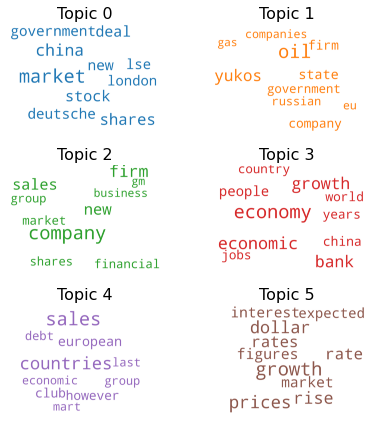

In [11]:
# Word Cloud: top 10 keywords in each topic
show_wordcloud(lda_b, nrows=3, ncols=2, figsize=(6, 6))

In [12]:
# Coherence score
show_coherence_score(lda_b, texts_b, dict_b)

Coherence Score:  0.519
Coherence per topic:  [0.469 0.568 0.463 0.568 0.337 0.712]


In [14]:
# Visualizing the topics with Intertopic Distance Map
vis_data_b = gensimvis.prepare(lda_b, corpus_b, dict_b)

#pyLDAvis.display(vis_data_b)
pyLDAvis.save_html(vis_data_b, 'maps/lda_1.html')

- On the intertopic distance map, most relevant 30 terms are represented for 6 topics.
- The areas of the 1st and 2nd circles encompass respectively 22.7% and 19.9% of tokens across the dictionary (topic 5 and topic 0).
- The circles 3, 4 and 5 have longer distance between each other. This indicates that they have less number of words in common.
- On the contrary, the 1st circle almost entirely overlaps the 5th circle. They share such key terms as 'economy', 'growth', 'rise', and 'rate'.
- Key terms in the 3rd circle allows to deduce that the topic is closely related to gas and oil, government and russian firms.

#### 2. Class: Entertainment

In [15]:
news_entertainmnt = get_data(df, 'class_label', 'entertainment')
texts_ent = process_data(news_entertainmnt, 'news_data')
print('')
dict_ent, corpus_ent = get_dict_corpus(texts_ent)

Dataset size: 2106
Sample from texts: [['gallery', 'interactive', 'tree'], ['christmas', 'tree', 'receive', 'text', 'messages', 'unveiled', 'london', 'tate', 'britain', 'art', 'gallery']]

Dictionary size: 6276
Sample from corpus: [[(0, 1), (1, 1), (2, 1)], [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [16]:
lda_ent = models.ldamodel.LdaModel(corpus=corpus_ent, id2word=dict_ent, num_topics=6,
                                   alpha='auto', eta='auto', iterations=20,
                                   random_state=42, passes=5)

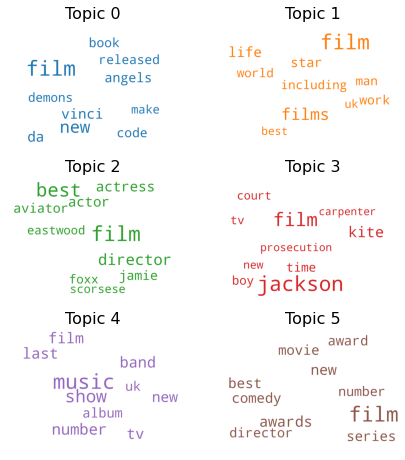

In [17]:
# Word Cloud: top 10 keywords in each topic
show_wordcloud(lda_ent, nrows=3, ncols=2)

In [18]:
# Coherence score
show_coherence_score(lda_ent, texts_ent, dict_ent)

Coherence Score:  0.436
Coherence per topic:  [0.259 0.39  0.846 0.245 0.446 0.429]


In [19]:
# Visualizing the topics with Intertopic Distance Map
vis_data_ent = gensimvis.prepare(lda_ent, corpus_ent, dict_ent)
pyLDAvis.save_html(vis_data_ent, 'maps/lda_2.html')

- On the intertopic distance map, most relevant 30 terms are represented for 6 topics.
- The area of the 1st circle encompasses 54.9% of tokens across the dictionary. The topic is definitely relates to 'music', 'show', 'record', 'band' and 'tv', since these terms are highly distributed within the topic (topic 4).
- The 1st circle overlaps the 3rd one, and both include the key terms such as 'film' and 'uk'.
- The 2nd, 5th and 6th circles have longer distance between each other. Though all topics share the key term 'film' for example, it can be observed that they are of different genres.

#### 3. Class: Politics

In [20]:
news_p = get_data(df, 'class_label', 'politics')
texts_p = process_data(news_p, 'news_data')
print('')
dict_p, corpus_p = get_dict_corpus(texts_p)

Dataset size: 2679
Sample from texts: [['labour', 'plans', 'maternity', 'pay', 'rise'], ['maternity', 'pay', 'new', 'mothers', 'rise', 'part', 'new', 'proposals', 'announced', 'trade', 'industry', 'secretary', 'patricia', 'hewitt']]

Dictionary size: 6616
Sample from corpus: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(1, 1), (2, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [21]:
lda_p = models.ldamodel.LdaModel(corpus=corpus_p, id2word=dict_p, num_topics=6,
                                   alpha='auto', eta='auto', iterations=20,
                                   random_state=42, passes=5)

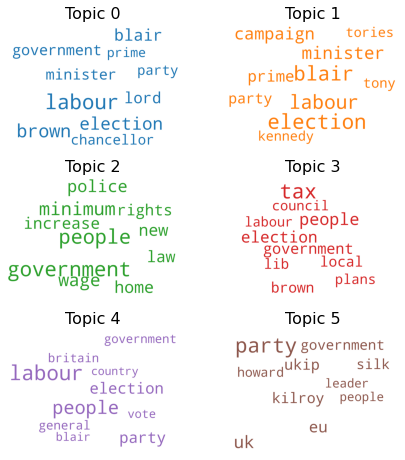

In [22]:
# Word Cloud: top 10 keywords in each topic
show_wordcloud(lda_p, nrows=3, ncols=2)

In [23]:
# Coherence score
show_coherence_score(lda_p, texts_p, dict_p)

Coherence Score:  0.442
Coherence per topic:  [0.513 0.514 0.387 0.541 0.386 0.311]


In [24]:
# Visualizing the topics with Intertopic Distance Map
vis_data_p = gensimvis.prepare(lda_p, corpus_p, dict_p)
pyLDAvis.save_html(vis_data_p, 'maps/lda_3.html')

- On the intertopic distance map, most relevant 30 terms are represented for 6 topics.
- The 1st and 2nd circles encompass respectively 21.4% and 19.3% of tokens across the dictionary (topic 0 and topic 2).
- The 4th circle is further away from the other topics. It is specifically about a British political party and politicians associated with it (topic 5).
- The 2nd circle is about 'people', 'rights' and 'government', and 'law' and 'police' (topic 2).

#### 4. Class: Sport

In [25]:
news_s = get_data(df, 'class_label', 'sport')
texts_s = process_data(news_s, 'news_data')
print('')
dict_s, corpus_s = get_dict_corpus(texts_s)

Dataset size: 2819
Sample from texts: [['claxton', 'major', 'medal'], ['british', 'hurdler', 'sarah', 'claxton', 'confident', 'win', 'major', 'medal', 'next', 'month', 'european', 'indoor', 'championships', 'madrid']]

Dictionary size: 6174
Sample from corpus: [[(0, 1), (1, 1), (2, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [26]:
lda_s = models.ldamodel.LdaModel(corpus=corpus_s, id2word=dict_s, num_topics=5,
                                   alpha='auto', eta='auto', iterations=20,
                                   random_state=42, passes=5)

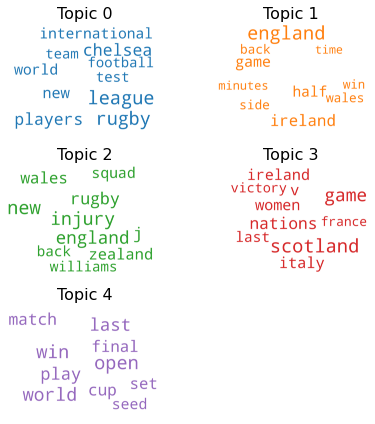

In [27]:
# Word Cloud: top 10 keywords in each topic
show_wordcloud(lda_s, nrows=3, ncols=2, figsize=(6, 6))

In [28]:
# Visualizing the topics with Intertopic Distance Map
vis_data_s = gensimvis.prepare(lda_s, corpus_s, dict_s)
pyLDAvis.save_html(vis_data_s, 'maps/lda_4.html')

- On the intertopic distance map, most relevant 30 terms are represented for 5 topics in sports.
- All topics are associated with various sports news:<br>
  -- the 2nd circle covers mostly 'rugby', 'football' (topic 0);<br>
  -- the 1st circle is about 'tennis', in particular the Australian 'open' 'world' tournament, 'matches' and tennis players (e.g. A.Roddick ('roddick') (topic 4);<br>
  -- the 3rd circle is about sports news of uk, or hosted in uk, since the top key terms are 'england', 'ireland' and 'wales' (topic 1).

#### 5. Class: Tech

In [29]:
news_t = get_data(df, 'class_label', 'tech')
texts_t = process_data(news_t, 'news_data')
print('')
dict_t, corpus_t = get_dict_corpus(texts_t)

Dataset size: 2569
Sample from texts: [['ink', 'helps', 'drive', 'democracy', 'asia'], ['kyrgyz', 'republic', 'small', 'mountainous', 'state', 'former', 'soviet', 'republic', 'using', 'invisible', 'ink', 'ultraviolet', 'readers', 'country', 'elections', 'part', 'drive', 'prevent', 'multiple', 'voting']]

Dictionary size: 7630
Sample from corpus: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(2, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


In [30]:
lda_t = models.ldamodel.LdaModel(corpus=corpus_t, id2word=dict_t, num_topics=8,
                                   alpha='auto', eta='auto', iterations=20,
                                   random_state=42, passes=5)

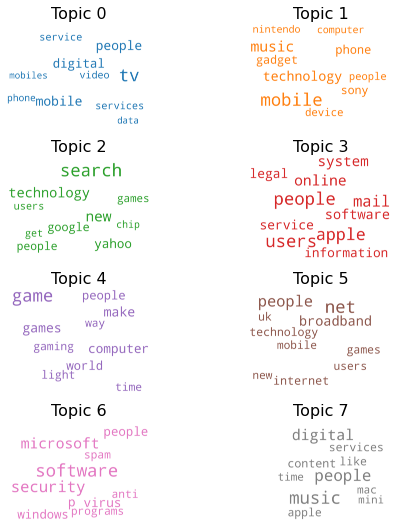

In [31]:
# Word Cloud: top 10 keywords in each topic
show_wordcloud(lda_t, nrows=4, ncols=2, figsize=(8, 7.5))

In [32]:
# Coherence score
show_coherence_score(lda_t, texts_t, dict_t)

Coherence Score:  0.416
Coherence per topic:  [0.521 0.465 0.231 0.33  0.323 0.408 0.616 0.437]


In [33]:
# Visualizing the topics with Intertopic Distance Map
vis_data_t = gensimvis.prepare(lda_t, corpus_t, dict_t)
pyLDAvis.save_html(vis_data_t, 'maps/lda_5.html')

- On the intertopic distance map, most relevant 30 terms are represented for 8 topics.
- The area of the 1st circle encompasses 17.9% of tokens across the dictionary.
- Five topics are close to each other on the map (topics: 5, 7, 0, 1, 2). All of them share 'technology', 'services', 'mobile' key terms. In particular, the 7th circle include terms related to 'games', 'playstation', and companies 'google' and 'yahoo'. Both the 2nd and 6th circles share 'music' key term.
- The 5th circle is about 'computer' 'games' and 'gaming' (topic 4).
- The 8th and 4th circles share the 'software' news. The 4th one is related to 'microsoft', 'security', 'windows', while the 8th one - to 'users', 'mail, and 'apple' (topics: 6, 3).